In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import string
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.manifold import TSNE

from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
from nltk.stem import WordNetLemmatizer 

from imblearn.over_sampling import SMOTE

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
def get_sentence_word_count(text_list):
    sent_count = 0
    word_count = 0
    vocab = {}
    for text in text_list:
        sentences=sent_tokenize(str(text).lower())
        sent_count = sent_count + len(sentences)
        for sentence in sentences:
            words=word_tokenize(sentence)
            for word in words:
                if(word in vocab.keys()):
                    vocab[word] = vocab[word] +1
                else:
                    vocab[word] =1 
    word_count = len(vocab.keys())
    return sent_count,word_count
    

In [3]:
data = pd.read_csv('/kaggle/input/medical-competition/medical-specialty-classification/Train.csv', usecols=['transcription', 'medical_specialty'])

data1 = pd.read_csv('/kaggle/input/specialty/Medical Transcription Samples.csv', usecols=['Transcription', 'Medical_Specialty'])
data2 = pd.read_csv('/kaggle/input/medicaltranscriptions/mtsamples.csv', usecols=['transcription', 'medical_specialty'])
data1 = data1.rename(columns={'Medical_Specialty': 'medical_specialty'})
data1 = data1.rename(columns={'Transcription': 'transcription'})
clinical_text_df = pd.concat([data, data1, data2], ignore_index=True, axis=0)

In [4]:
clinical_text_df.head(5)

,medical_specialty,transcription
0,Cardiovascular / Pulmonary,"HISTORY OF PRESENT ILLNESS: , The patient is a..."
1,Cardiovascular / Pulmonary,"REASON FOR CONSULTATION:, Pericardial effusio..."
2,Dermatology,"SUBJECTIVE:, This is a 29-year-old Vietnamese..."
3,Surgery,"PREOPERATIVE DIAGNOSIS: , Recurrent degenerati..."
4,IME-QME-Work Comp etc.,"DATE OF INJURY : October 4, 2000,DATE OF EXAMI..."


In [5]:
clinical_text_df = clinical_text_df[clinical_text_df['transcription'].notna()]
sent_count,word_count= get_sentence_word_count(clinical_text_df['transcription'].tolist())
print("Number of sentences in transcriptions column: "+ str(sent_count))
print("Number of unique words in transcriptions column: "+str(word_count))



data_categories  = clinical_text_df.groupby(clinical_text_df['medical_specialty'])
i = 1
print('===========Original Categories =======================')
for catName,dataCategory in data_categories:
    print('Cat:'+str(i)+' '+catName + ' : '+ str(len(dataCategory)) )
    i = i+1
print('==================================')

Number of sentences in transcriptions column: 367332
Number of unique words in transcriptions column: 35833
===========Original Categories =======================
Cat:1  Allergy / Immunology : 19
Cat:2  Autopsy : 18
Cat:3  Bariatrics : 48
Cat:4  Cardiovascular / Pulmonary : 1050
Cat:5  Chiropractic : 39
Cat:6  Consult - History and Phy. : 1342
Cat:7  Cosmetic / Plastic Surgery : 73
Cat:8  Dentistry : 75
Cat:9  Dermatology : 81
Cat:10  Diets and Nutritions : 20
Cat:11  Discharge Summary : 291
Cat:12  ENT - Otolaryngology : 269
Cat:13  Emergency Room Reports : 150
Cat:14  Endocrinology : 52
Cat:15  Gastroenterology : 631
Cat:16  General Medicine : 706
Cat:17  Hematology - Oncology : 252
Cat:18  Hospice - Palliative Care : 12
Cat:19  IME-QME-Work Comp etc. : 45
Cat:20  Lab Medicine - Pathology : 24
Cat:21  Letters : 64
Cat:22  Nephrology : 231
Cat:23  Neurology : 612
Cat:24  Neurosurgery : 261
Cat:25  Obstetrics / Gynecology : 310
Cat:26  Office Notes : 134
Cat:27  Ophthalmology : 230
Cat

In [6]:
filtered_data_categories = data_categories.filter(lambda x:x.shape[0] > 50)
final_data_categories = filtered_data_categories.groupby(filtered_data_categories['medical_specialty'])
i=1
print('============Reduced Categories ======================')
for catName,dataCategory in final_data_categories:
    print('Cat:'+str(i)+' '+catName + ' : '+ str(len(dataCategory)) )
    i = i+1

print('============ Reduced Categories ======================')

============Reduced Categories ======================
Cat:1  Cardiovascular / Pulmonary : 1050
Cat:2  Consult - History and Phy. : 1342
Cat:3  Cosmetic / Plastic Surgery : 73
Cat:4  Dentistry : 75
Cat:5  Dermatology : 81
Cat:6  Discharge Summary : 291
Cat:7  ENT - Otolaryngology : 269
Cat:8  Emergency Room Reports : 150
Cat:9  Endocrinology : 52
Cat:10  Gastroenterology : 631
Cat:11  General Medicine : 706
Cat:12  Hematology - Oncology : 252
Cat:13  Letters : 64
Cat:14  Nephrology : 231
Cat:15  Neurology : 612
Cat:16  Neurosurgery : 261
Cat:17  Obstetrics / Gynecology : 310
Cat:18  Office Notes : 134
Cat:19  Ophthalmology : 230
Cat:20  Orthopedic : 1004
Cat:21  Pain Management : 176
Cat:22  Pediatrics - Neonatal : 140
Cat:23  Physical Medicine - Rehab : 59
Cat:24  Podiatry : 137
Cat:25  Psychiatry / Psychology : 128
Cat:26  Radiology : 771
Cat:27  SOAP / Chart / Progress Notes : 462
Cat:28  Sleep Medicine : 57
Cat:29  Surgery : 2951
Cat:30  Urology : 312
============ Reduced Categories

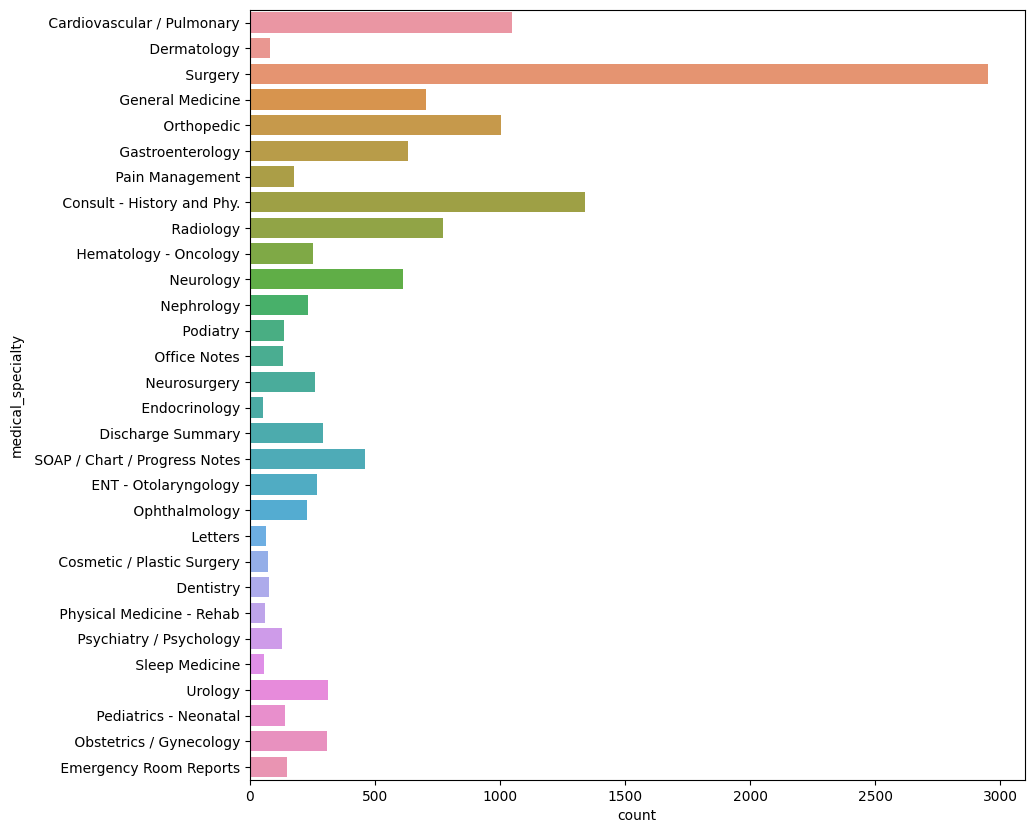

In [7]:
plt.figure(figsize=(10,10))
sns.countplot(y='medical_specialty', data = filtered_data_categories )
plt.show()

In [8]:
data = filtered_data_categories[['transcription', 'medical_specialty']]
data = data.drop(data[data['transcription'].isna()].index)
data.shape

(13011, 2)

In [9]:
def clean_text(text ): 
    text = text.translate(str.maketrans('', '', string.punctuation))
    text1 = ''.join([w for w in text if not w.isdigit()]) 
    REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
    #BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
    
    text2 = text1.lower()
    text2 = REPLACE_BY_SPACE_RE.sub('', text2) # replace REPLACE_BY_SPACE_RE symbols by space in text
    #text2 = BAD_SYMBOLS_RE.sub('', text2)
    return text2

import spacy

# Load the language model
nlp = spacy.load('en_core_web_sm')

# Define the lemmatize_text function
def lemmatize_text(text):
    doc = nlp(text)
    lemmatized_tokens = [token.lemma_ for token in doc]
    return ' '.join(lemmatized_tokens)

In [10]:

# Apply lemmatization and cleaning to the 'description' column
data['transcription'] = data['transcription'].apply(lemmatize_text)
data['transcription'] = data['transcription'].apply(clean_text)

In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(analyzer='word', stop_words='english', ngram_range=(1, 3), max_df=0.75, use_idf=True, smooth_idf=True, max_features=1000)
tfIdfMat = vectorizer.fit_transform(data['transcription'].tolist())
feature_names = sorted(vectorizer.get_feature_names_out())  # Modified line


In [12]:
import gc

gc.collect()
vectorizer = TfidfVectorizer(analyzer='word', stop_words='english', ngram_range=(1, 3), max_df=0.75, use_idf=True, smooth_idf=True, max_features=1000)
tfIdfMat = vectorizer.fit_transform(data['transcription'].tolist())
labels = data['medical_specialty'].tolist()
category_list = data.medical_specialty.unique()
X_train, X_test, y_train, y_test = train_test_split(tfIdfMat, labels, stratify=labels, random_state=42)

In [13]:
filtered_data_categories['medical_specialty'] =filtered_data_categories['medical_specialty'].apply(lambda x:str.strip(x))
mask = filtered_data_categories['medical_specialty'] == 'Surgery'
filtered_data_categories = filtered_data_categories[~mask]
final_data_categories = filtered_data_categories.groupby(filtered_data_categories['medical_specialty'])
mask = filtered_data_categories['medical_specialty'] == 'SOAP / Chart / Progress Notes'
filtered_data_categories = filtered_data_categories[~mask]
mask = filtered_data_categories['medical_specialty'] == 'Office Notes'
filtered_data_categories = filtered_data_categories[~mask]
mask = filtered_data_categories['medical_specialty'] == 'Consult - History and Phy.'
filtered_data_categories = filtered_data_categories[~mask]
mask = filtered_data_categories['medical_specialty'] == 'Emergency Room Reports'
filtered_data_categories = filtered_data_categories[~mask]
mask = filtered_data_categories['medical_specialty'] == 'Discharge Summary'
filtered_data_categories = filtered_data_categories[~mask]

'''
mask = filtered_data_categories['medical_specialty'] == 'Pediatrics - Neonatal'
filtered_data_categories = filtered_data_categories[~mask]
'''
mask = filtered_data_categories['medical_specialty'] == 'Pain Management'
filtered_data_categories = filtered_data_categories[~mask]
mask = filtered_data_categories['medical_specialty'] == 'General Medicine'
filtered_data_categories = filtered_data_categories[~mask]


mask = filtered_data_categories['medical_specialty'] == 'Neurosurgery'
filtered_data_categories.loc[mask, 'medical_specialty'] = 'Neurology'
mask = filtered_data_categories['medical_specialty'] == 'Nephrology'
filtered_data_categories.loc[mask, 'medical_specialty'] = 'Urology'


i=1
print('============Reduced Categories======================')
for catName,dataCategory in final_data_categories:
    print('Cat:'+str(i)+' '+catName + ' : '+ str(len(dataCategory)) )
    i = i+1

print('============Reduced Categories======================')


data = filtered_data_categories[['transcription', 'medical_specialty']]
data = data.drop(data[data['transcription'].isna()].index)
data.shape

============Reduced Categories======================
Cat:1 Cardiovascular / Pulmonary : 1050
Cat:2 Consult - History and Phy. : 1342
Cat:3 Cosmetic / Plastic Surgery : 73
Cat:4 Dentistry : 75
Cat:5 Dermatology : 81
Cat:6 Discharge Summary : 291
Cat:7 ENT - Otolaryngology : 269
Cat:8 Emergency Room Reports : 150
Cat:9 Endocrinology : 52
Cat:10 Gastroenterology : 631
Cat:11 General Medicine : 706
Cat:12 Hematology - Oncology : 252
Cat:13 Letters : 64
Cat:14 Nephrology : 231
Cat:15 Neurology : 612
Cat:16 Neurosurgery : 261
Cat:17 Obstetrics / Gynecology : 310
Cat:18 Office Notes : 134
Cat:19 Ophthalmology : 230
Cat:20 Orthopedic : 1004
Cat:21 Pain Management : 176
Cat:22 Pediatrics - Neonatal : 140
Cat:23 Physical Medicine - Rehab : 59
Cat:24 Podiatry : 137
Cat:25 Psychiatry / Psychology : 128
Cat:26 Radiology : 771
Cat:27 SOAP / Chart / Progress Notes : 462
Cat:28 Sleep Medicine : 57
Cat:29 Urology : 312
============Reduced Categories======================


(6799, 2)

In [14]:
import spacy

nlp = spacy.load("en_core_web_sm")

In [15]:
def process_Text( text):
    wordlist=[]
    doc = nlp(text)
    for ent in doc.ents:
        wordlist.append(ent.text)
    return ' '.join(wordlist)    

In [16]:
data['transcription'] = data['transcription'].apply(process_Text)
data['transcription'] = data['transcription'].apply(lemmatize_text)
data['transcription'] = data['transcription'].apply(clean_text)

In [17]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(analyzer='word', stop_words='english', ngram_range=(1, 3), max_df=0.75, use_idf=True, smooth_idf=True, max_features=1000)
tfIdfMat = vectorizer.fit_transform(data['transcription'].tolist())
feature_names = sorted(vectorizer.get_feature_names_out())  # Modified line


/tmp/ipykernel_26/1628745963.py:11: UserWarning: The palette list has more values (21) than needed (20), which may not be intended.
  sns.scatterplot(


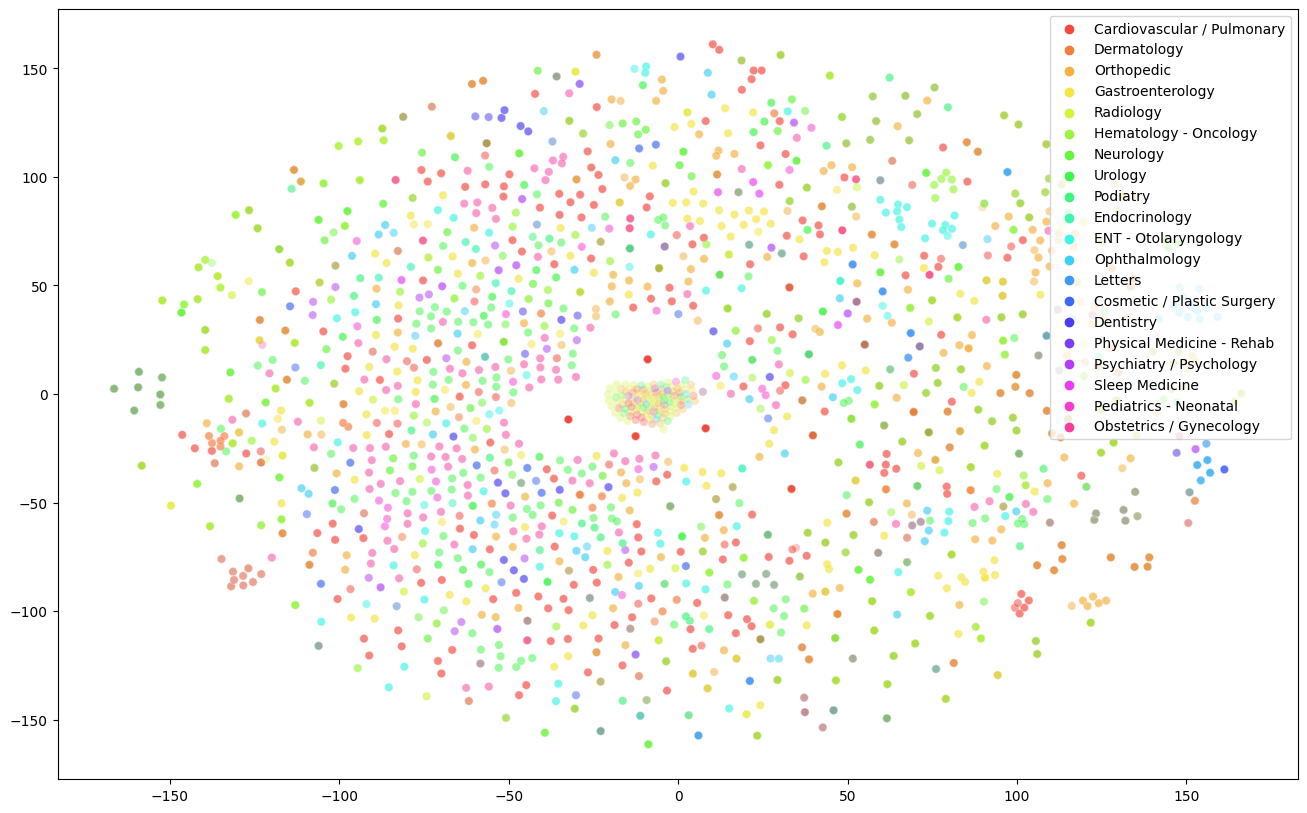

In [18]:
import gc
gc.collect()

tfIdfMatrix = np.asarray(tfIdfMat.todense())  # Convert to numpy array
labels = data['medical_specialty'].tolist()

tsne_results = TSNE(n_components=2, init='random', random_state=0, perplexity=40).fit_transform(tfIdfMatrix)

plt.figure(figsize=(16, 10))
palette = sns.hls_palette(21, l=.6, s=.9)
sns.scatterplot(
    x=tsne_results[:, 0],
    y=tsne_results[:, 1],
    hue=labels,
    palette=palette,
    legend="full",
    alpha=0.3
)
plt.show()

In [19]:
pca = PCA(n_components=0.99)
tfIdfMat_reduced = pca.fit_transform(tfIdfMat.toarray())
labels = data['medical_specialty'].tolist()
category_list = data.medical_specialty.unique()
X_train, X_test, y_train, y_test = train_test_split(tfIdfMat_reduced, labels, stratify=labels,random_state=42)   


In [20]:
print('Train_Set_Size:'+str(X_train.shape))
print('Test_Set_Size:'+str(X_test.shape))

Train_Set_Size:(5099, 758)
Test_Set_Size:(1700, 758)


In [21]:
from sklearn.neural_network import MLPClassifier


In [22]:
mlp = MLPClassifier(random_state=42, max_iter=300).fit(X_train, y_train)
y_test_pred= mlp.predict(X_test)

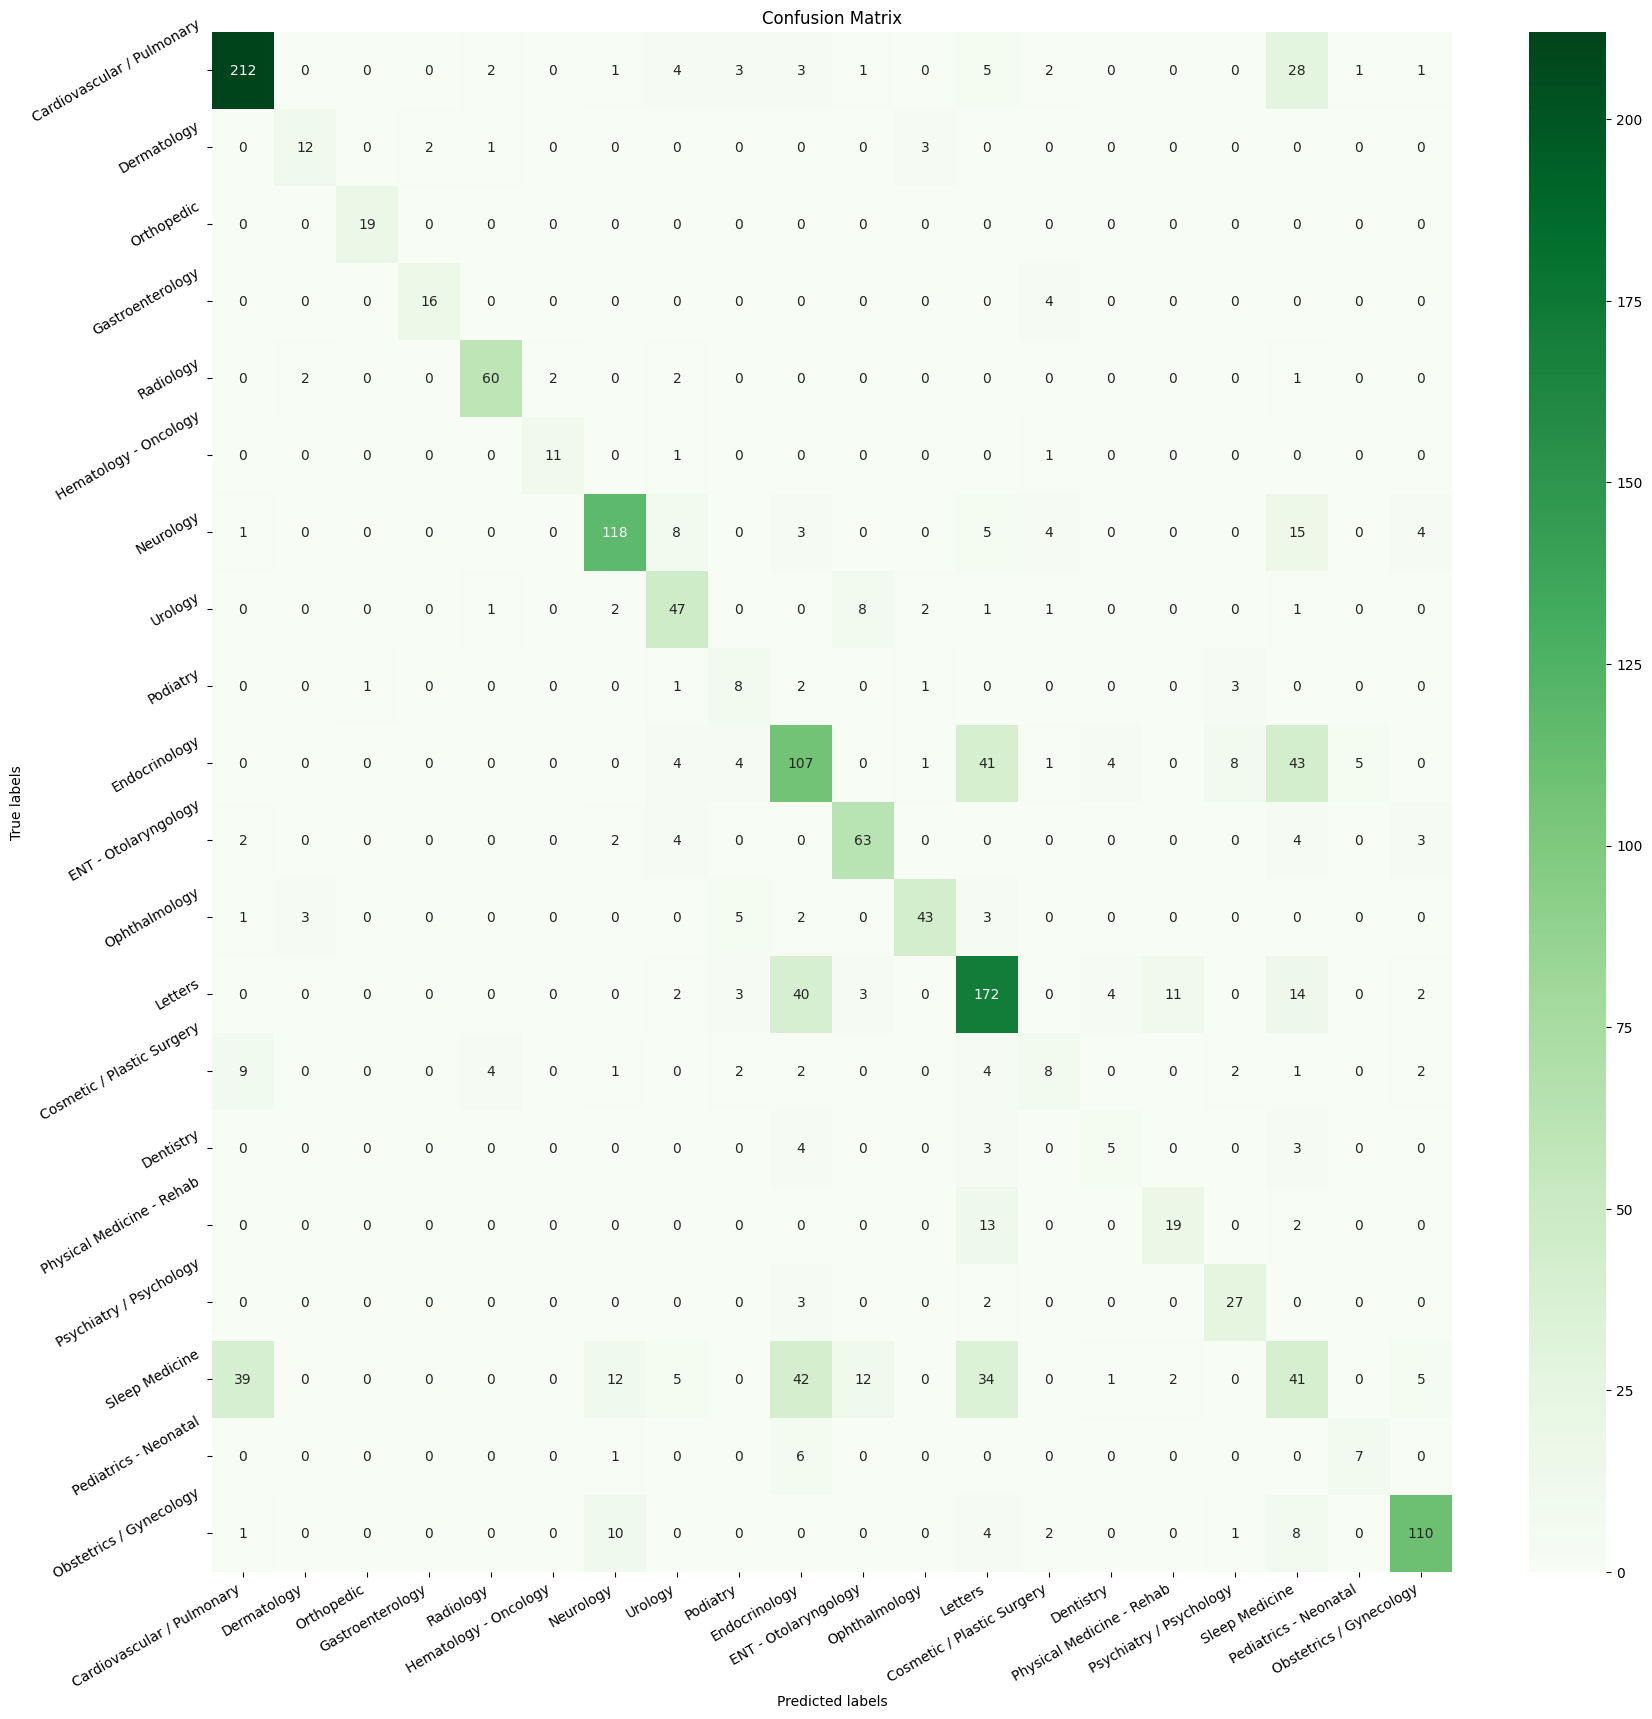

                            precision    recall  f1-score   support

Cardiovascular / Pulmonary       0.80      0.81      0.80       263
Cosmetic / Plastic Surgery       0.71      0.67      0.69        18
                 Dentistry       0.95      1.00      0.97        19
               Dermatology       0.89      0.80      0.84        20
      ENT - Otolaryngology       0.88      0.90      0.89        67
             Endocrinology       0.85      0.85      0.85        13
          Gastroenterology       0.80      0.75      0.77       158
     Hematology - Oncology       0.60      0.75      0.67        63
                   Letters       0.32      0.50      0.39        16
                 Neurology       0.50      0.49      0.50       218
   Obstetrics / Gynecology       0.72      0.81      0.76        78
             Ophthalmology       0.86      0.75      0.80        57
                Orthopedic       0.60      0.69      0.64       251
     Pediatrics - Neonatal       0.35      0.23

In [23]:
labels = category_list
cm = confusion_matrix(y_test, y_test_pred)

fig = plt.figure(figsize=(20,20))
ax= fig.add_subplot(1,1,1)
sns.heatmap(cm, annot=True, cmap="Greens",ax = ax,fmt='g'); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(labels); ax.yaxis.set_ticklabels(labels);
plt.setp(ax.get_yticklabels(), rotation=30, horizontalalignment='right')
plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')     
plt.show()
print(classification_report(y_test,y_test_pred))

In [24]:
smote_over_sample = SMOTE(sampling_strategy='minority')
labels = data['medical_specialty'].tolist()
X, y = smote_over_sample.fit_resample(tfIdfMat_reduced, labels)

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y,random_state=1)   
print('Train_Set_Size:'+str(X_train.shape))
print('Test_Set_Size:'+str(X_test.shape))

Train_Set_Size:(5847, 758)
Test_Set_Size:(1950, 758)


In [25]:
clf = LogisticRegression(penalty= 'elasticnet', solver= 'saga', l1_ratio=0.5, random_state=42).fit(X_train, y_train)
y_test_pred= clf.predict(X_test)

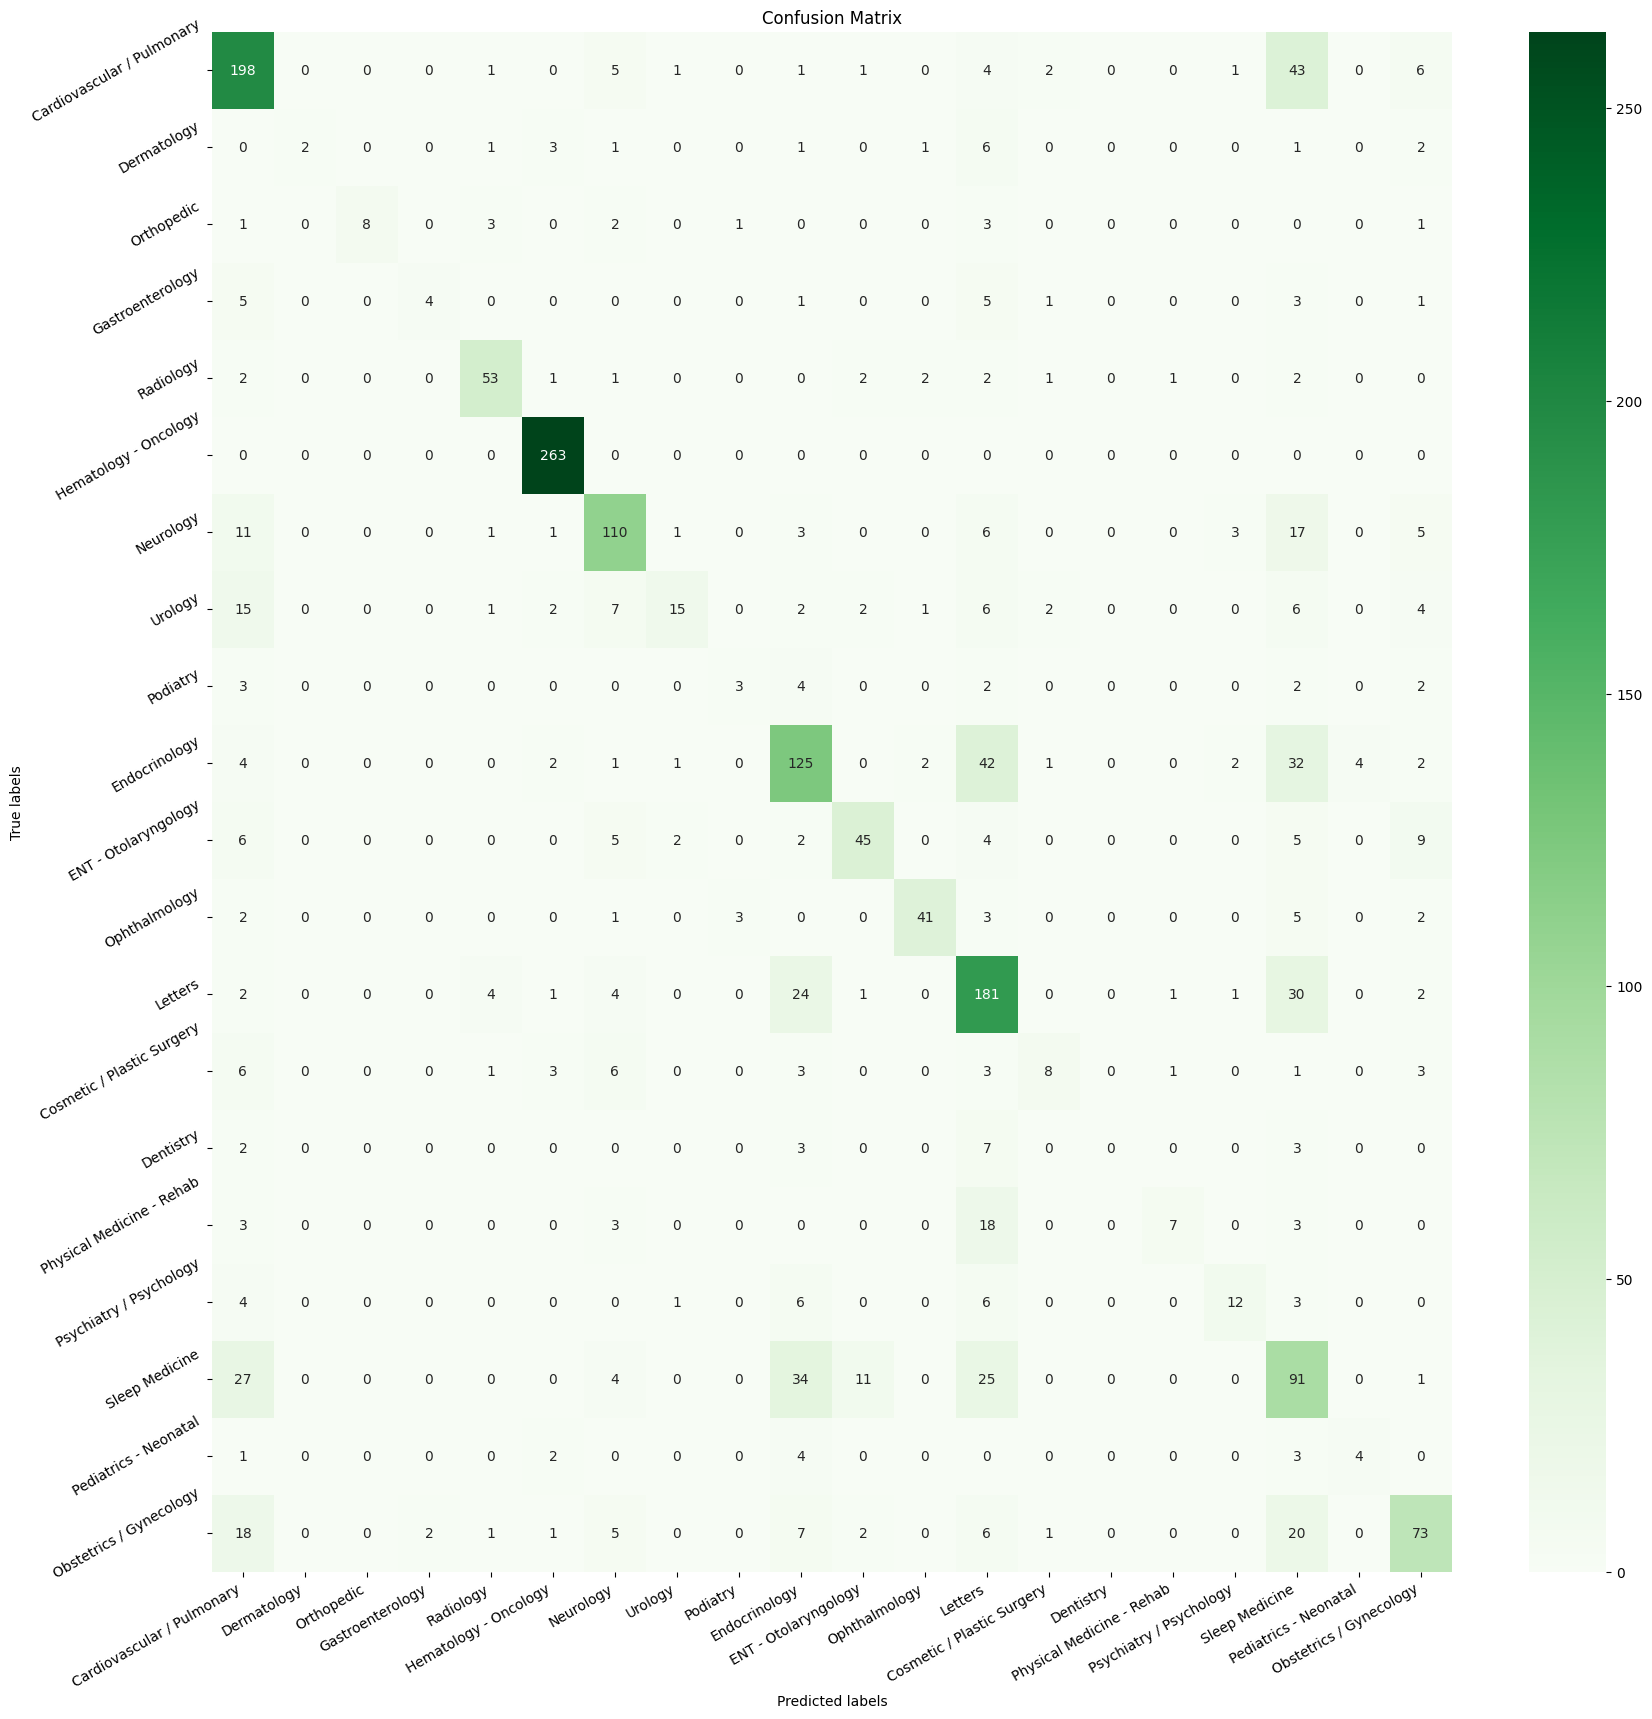

                            precision    recall  f1-score   support

Cardiovascular / Pulmonary       0.64      0.75      0.69       263
Cosmetic / Plastic Surgery       1.00      0.11      0.20        18
                 Dentistry       1.00      0.42      0.59        19
               Dermatology       0.67      0.20      0.31        20
      ENT - Otolaryngology       0.80      0.79      0.80        67
             Endocrinology       0.94      1.00      0.97       263
          Gastroenterology       0.71      0.70      0.70       158
     Hematology - Oncology       0.71      0.24      0.36        63
                   Letters       0.43      0.19      0.26        16
                 Neurology       0.57      0.57      0.57       218
   Obstetrics / Gynecology       0.70      0.58      0.63        78
             Ophthalmology       0.87      0.72      0.79        57
                Orthopedic       0.55      0.72      0.62       251
     Pediatrics - Neonatal       0.50      0.23

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [26]:
labels = category_list
cm = confusion_matrix(y_test, y_test_pred)

fig = plt.figure(figsize=(20,20))
ax= fig.add_subplot(1,1,1)
sns.heatmap(cm, annot=True, cmap="Greens",ax = ax,fmt='g'); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(labels); ax.yaxis.set_ticklabels(labels);
plt.setp(ax.get_yticklabels(), rotation=30, horizontalalignment='right')
plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')     
plt.show()
print(classification_report(y_test,y_test_pred))

In [27]:
import pickle

filename = '/kaggle/working/my_model.pkl'
with open(filename, 'wb') as file:
    pickle.dump(clf, file)


In [28]:
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer

t = 'i have pain in heart when breathing '

vectorizer = TfidfVectorizer(analyzer='word', stop_words='english', ngram_range=(1, 3), max_df=1.0, min_df=1, use_idf=True, smooth_idf=True, max_features=1000)
tfIdfMat = vectorizer.fit_transform([t])
tfIdfMat_array = tfIdfMat.toarray()

# Check if the number of features in tfIdfMat_array matches the number of features in the training data
if tfIdfMat_array.shape[1] < 758:
    # Pad tfIdfMat_array with zeros for the additional features
    n_additional_features = 758 - tfIdfMat_array.shape[1]
    tfIdfMat_array_padded = np.pad(tfIdfMat_array, ((0, 0), (0, n_additional_features)), mode='constant')
else:
    tfIdfMat_array_padded = tfIdfMat_array

# Make predictions using the padded input data
predictions = mlp.predict(tfIdfMat_array_padded)

print(predictions)

['Neurology']
